# 5. Finding and Extracting Communities (Q5)

Airlines can optimize their operations by identifying communities within a flight network. These communities represent groups of airports with strong connections, helping airlines pinpoint high-demand regions for expansion or underserved areas for consolidation. By analyzing these communities, airlines can improve resource allocation, reduce costs, and enhance service quality.

In this task, you are asked to analyze the graph and identify the communities based on the flight network provided. For the airline, the primary focus is on the cities, so your communities should reflect the connectivity between cities through the flights that link them.

In [ ]:
import networkx as nx
import pandas as pd

G = nx.Graph()
df = pd.read_csv("C:/Users/EMILIO/Documents/università/ADM/ADM-HW5/ADM-HW5/Airports2.csv")

for _, row in df.iterrows():
    origin = row['Origin_airport']
    destination = row['Destination_airport']
    weight = row['Flights'] 
    if G.has_edge(origin, destination):
        G[origin][destination]['weight'] += weight  
    else:
        G.add_edge(origin, destination, weight=weight)

print("Numero di nodi:", G.number_of_nodes())
print("Numero di archi:", G.number_of_edges())

Numero di nodi: 727
Numero di archi: 23260


In [ ]:
import networkx as nx
from collections import defaultdict
import random
import time

def compute_modularity(graph, communities, m):
    Q = 0.0
    for u, v, data in graph.edges(data=True):
        weight = data.get("weight", 1.0)
        if communities[u] == communities[v]:
            ki = sum(data.get("weight", 1.0) for _, _, data in graph.edges(u, data=True))
            kj = sum(data.get("weight", 1.0) for _, _, data in graph.edges(v, data=True))
            Q += weight - (ki * kj) / (2 * m)
    return Q / (2 * m)

def louvain_with_max_iterations(graph, max_iterations=300):

    communities = {node: i for i, node in enumerate(graph.nodes())}
    m = sum(data.get("weight", 1.0) for _, _, data in graph.edges(data=True)) / 2 

    print(f"Numero totale di nodi: {len(graph.nodes())}, Peso totale del grafo (2m): {2 * m}")

    improvement = True
    iteration = 0
    modularity_history = []  

    while iteration < max_iterations:
        iteration += 1
        improvement = False
        nodes = list(graph.nodes())
        random.shuffle(nodes)  

        print(f"\nInizio iterazione {iteration} - Numero di nodi: {len(nodes)}")

        for node in nodes:
            best_community = communities[node]
            best_increase = 0
            current_community = communities[node]

            neighbor_communities = defaultdict(float)
            for neighbor in graph.neighbors(node):
                weight = graph[node][neighbor].get("weight", 1.0)
                neighbor_communities[communities[neighbor]] += weight

            for community, weight_sum in neighbor_communities.items():
                ki = sum(data.get("weight", 1.0) for _, _, data in graph.edges(node, data=True))
                sigma_tot = sum(
                    sum(data.get("weight", 1.0) for _, _, data in graph.edges(n, data=True))
                    for n in graph.nodes()
                    if communities[n] == community
                )
                delta_Q = (weight_sum - (ki * sigma_tot) / (2 * m))

                if delta_Q > best_increase:
                    best_community = community
                    best_increase = delta_Q

            if best_community != current_community:
                communities[node] = best_community
                improvement = True

        current_modularity = compute_modularity(graph, communities, m)
        modularity_history.append(current_modularity)

        print(f"Iterazione {iteration} - Modularità: {current_modularity:.6f}")
        print(f"Tempo trascorso finora: {time.time() - start_time:.2f} secondi")

    print(f"\nNumero massimo di iterazioni ({max_iterations}) raggiunto.")
    print("Algoritmo terminato.")

    community_groups = defaultdict(list)
    for node, community in communities.items():
        community_groups[community].append(node)

    return list(community_groups.values())

start_time = time.time()
communities = louvain_with_max_iterations(G, max_iterations=300)
end_time = time.time()

print(f"Numero di comunità rilevate: {len(communities)}")
for i, community in enumerate(communities):
    print(f"Comunità {i+1}: {community}")
print(f"Tempo totale di esecuzione: {end_time - start_time:.2f} secondi")


Numero totale di nodi: 727, Peso totale del grafo (2m): 134277303.0

Inizio iterazione 1 - Numero di nodi: 727
Iterazione 1 - Modularità: 0.068297
Tempo trascorso finora: 5.60 secondi

Inizio iterazione 2 - Numero di nodi: 727
Iterazione 2 - Modularità: 0.091476
Tempo trascorso finora: 11.04 secondi

Inizio iterazione 3 - Numero di nodi: 727
Iterazione 3 - Modularità: 0.097166
Tempo trascorso finora: 16.57 secondi

Inizio iterazione 4 - Numero di nodi: 727
Iterazione 4 - Modularità: 0.101628
Tempo trascorso finora: 22.58 secondi

Inizio iterazione 5 - Numero di nodi: 727
Iterazione 5 - Modularità: 0.099504
Tempo trascorso finora: 28.15 secondi

Inizio iterazione 6 - Numero di nodi: 727
Iterazione 6 - Modularità: 0.099979
Tempo trascorso finora: 33.73 secondi

Inizio iterazione 7 - Numero di nodi: 727
Iterazione 7 - Modularità: 0.109189
Tempo trascorso finora: 39.44 secondi

Inizio iterazione 8 - Numero di nodi: 727
Iterazione 8 - Modularità: 0.111362
Tempo trascorso finora: 45.35 secon

we can visualize the results of the communities by plotting them on the map of USA. 

In [ ]:
import folium
import random
from matplotlib.colors import rgb2hex
import matplotlib.pyplot as plt


def visualize_communities_on_map(graph, communities, airport_data):
    """
    Visualizza le comunità su una mappa interattiva con Folium.
    
    Args:
        graph: Il grafo contenente gli aeroporti.
        communities: Lista delle comunità (ogni comunità è una lista di nodi).
        airport_data: DataFrame con informazioni sugli aeroporti, incluse latitudine e longitudine.
    """

    map_center = [39.8283, -98.5795]  
    folium_map = folium.Map(location=map_center, zoom_start=5)

    cmap = plt.get_cmap('tab10', len(communities))
    community_colors = [rgb2hex(cmap(i)[:3]) for i in range(len(communities))]

    for idx, community in enumerate(communities):
        color = community_colors[idx]
        for airport in community:
            if airport in airport_data.index:
                lat = airport_data.loc[airport, 'latitude']
                lon = airport_data.loc[airport, 'longitude']
                folium.CircleMarker(
                    location=(lat, lon),
                    radius=5,
                    color=color,
                    fill=True,
                    fill_opacity=0.7,
                    tooltip=f"Aeroporto: {airport} (Comunità {idx})"
                ).add_to(folium_map)

    return folium_map

import pandas as pd
airport_data = pd.read_csv("C:/Users/EMILIO/Documents/università/ADM/ADM-HW5/ADM-HW5/airport_coordinates_.csv", sep=";")
airport_data.set_index("airport_code", inplace=True)
airport_data["latitude"] = pd.to_numeric(airport_data["latitude"], errors="coerce")
airport_data["longitude"] = pd.to_numeric(airport_data["longitude"], errors="coerce")


map_communities = visualize_communities_on_map(G, communities, airport_data)
map_communities.save("communities_map.html")  
map_communities


### Function Inputs and Outputs

#### Inputs:
1. **Flight Network**: The network of flights represented as a graph.
2. **Airport 1 code `c1`**: The code of the first airport.
3. **Airport 2 code `c2`**: The code of the second airport.

#### Outputs:
1. **Total Number of Communities**: 
   - The function calculates and displays the total number of communities detected in the flight network.
2. **Cities in Each Community**:
   - The function lists the cities belonging to each community.
3. **Graph Visualization**:
   - A visualization of the flight network graph highlighting the communities, where each community is represented in a different color.
4. **Community Check for `c1` and `c2`**:
   - The function checks if the two input airports (`c1` and `c2`) belong to the same community and returns the result.


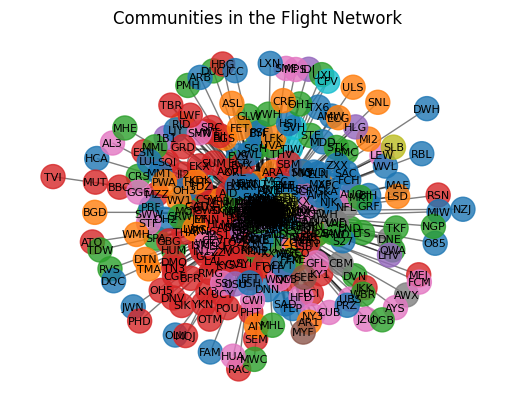

Total number of communities: 31
Community 1: ['MHK', 'AMW', 'OMA', 'FOE', 'LBF', 'MCI', 'GRI', 'SPI', 'DEC', 'STL', 'EVV', 'IND', 'SLN', 'UIN', 'MDW', 'DET', 'EAR', 'BRL', 'JLN', 'TBN', 'COU', 'MWA', 'IRK', 'PAH', 'OFK', 'CGI', 'DNN', 'MKL', 'LUL', 'WVL', 'FEP', 'CGX', 'STP', 'PSF', 'OWB', 'PBF', 'OH3', 'OH2', 'MMT', 'OLU', 'HSI', 'ARB', 'JWN', 'FAM', 'DQC', 'LXN', 'MIW']
Community 2: ['EUG', 'RDM', 'MFR', 'SEA', 'PDX', 'LMT', 'EAT', 'YKM', 'SLE', 'GEG', 'AST', 'CLM', 'PDT', 'BFI', 'MWH', 'RBG', 'FBK', 'ANC', 'BLI', 'FAI', 'KTN', 'FWH', 'RIV', 'TCM', 'NKX', 'EIL', 'EDF', 'NZY', 'CVO', 'CHI', 'JNU', 'JSE', 'ADQ', 'ALW', 'SKA', 'DLF', 'MDD', 'OLM', 'IAB', 'ODW', 'MVW', 'ELN', 'LGD', 'SFF', 'MRI', 'HCA', 'ZXX', 'PRZ', 'JCC']
Community 3: ['SFO', 'LAX', 'RDD', 'SJC', 'ACV', 'SMF', 'PHX', 'FAT', 'TUS', 'RNO', 'CIC', 'ABQ', 'LAS', 'CEC', 'SAN', 'STS', 'DRO', 'OAK', 'ROW', 'BFL', 'SBA', 'YUM', 'MOD', 'SCK', 'PRB', 'MCE', 'SNA', 'APC', 'SCF', 'HIK', 'LRU', 'TSM', 'FLG', 'HII', 'IPL', 'SBP', 'E

In [29]:
import matplotlib.pyplot as plt
from matplotlib.colors import rgb2hex

def same_community(city1, city2, communities):
    for community in communities:
        if city1 in community and city2 in community:
            return True
    return False

def visualize_communities(graph, communities):
    pos = nx.spring_layout(graph)  
    cmap = plt.get_cmap('tab10')
    node_colors = {}
    for idx, community in enumerate(communities):
        color = rgb2hex(cmap(idx / len(communities))[:3])
        for node in community:
            node_colors[node] = color

    nx.draw_networkx_nodes(
        graph, pos, 
        node_color=[node_colors[node] for node in graph.nodes()], 
        node_size=300, 
        alpha=0.8
    )
    nx.draw_networkx_edges(graph, pos, alpha=0.5)
    nx.draw_networkx_labels(graph, pos, font_size=8)

    plt.title("Communities in the Flight Network")
    plt.axis("off")
    plt.show()
def analyze_flight_network(graph, communities, city1, city2):

    total_communities = len(communities)
    community_dict = {f"Community {i+1}": list(community) for i, community in enumerate(communities)}
    same_community_flag = same_community(city1, city2, communities)
    visualize_communities(graph, communities)
    print(f"Total number of communities: {total_communities}")
    for community_name, cities in community_dict.items():
        print(f"{community_name}: {cities}")

    print(f"The airpors {city1} and {city2} are in the same community: {same_community_flag}")


analyze_flight_network(G, communities, "SVC", "NZJ")


In [32]:
import networkx as nx
from collections import Counter, defaultdict
import random
import time

def label_propagation(graph, max_iterations=100):
    """
    Algoritmo di Label Propagation per la rilevazione delle comunità.
    
    Args:
        graph (nx.Graph): Grafo di input.
        max_iterations (int): Numero massimo di iterazioni.
    
    Returns:
        List[List[str]]: Liste di nodi raggruppati per comunità.
    """

    labels = {node: node for node in graph.nodes()}
    iteration = 0

    while iteration < max_iterations:
        iteration += 1
        changes = 0
        
        nodes = list(graph.nodes())
        random.shuffle(nodes)

        for node in nodes:
            neighbor_labels = [labels[neighbor] for neighbor in graph.neighbors(node)]
            if not neighbor_labels:
                continue
            most_common_label = Counter(neighbor_labels).most_common(1)[0][0]
            
            if labels[node] != most_common_label:
                labels[node] = most_common_label
                changes += 1

        if changes == 0:
            print(f"Convergency found at the iteration: {iteration}.")
            break
    
    communities = defaultdict(list)
    for node, label in labels.items():
        communities[label].append(node)
    
    return list(communities.values())

start_time = time.time()
communities_chat = label_propagation(G)
end_time = time.time()

print(f"Number of communities found: {len(communities_chat)}")
for i, community in enumerate(communities_chat):
    print(f"Community {i+1}: {community}")
print(f"Total execution time: {end_time - start_time:.2f} seconds")


Convergency found at the iteration: 4.
Number of communities found: 1
Community 1: ['MHK', 'AMW', 'EUG', 'RDM', 'MFR', 'SEA', 'PDX', 'LMT', 'SFO', 'LAX', 'EAT', 'YKM', 'EKO', 'SLE', 'GEG', 'RDD', 'LWS', 'AST', 'CLM', 'PDT', 'SJC', 'ACV', 'PUW', 'SMF', 'FLL', 'PHX', 'BFI', 'GGG', 'GTF', 'FAT', 'TUS', 'MWH', 'BIL', 'DFW', 'RBG', 'SLC', 'CPR', 'RNO', 'FBK', 'ANC', 'BIF', 'CIC', 'SAF', 'ABQ', 'FSM', 'LAS', 'DQF', 'ICT', 'AZA', 'DLH', 'CEC', 'OKC', 'SAN', 'STS', 'DRO', 'OAK', 'IAH', 'ELP', 'DBQ', 'HLN', 'TUL', 'OMA', 'ACT', 'BTM', 'AUS', 'PIA', 'CWA', 'PUB', 'FOE', 'COS', 'GJT', 'LBF', 'SPS', 'CYS', 'ABR', 'BRD', 'AMA', 'ROW', 'BIS', 'MSO', 'GCC', 'LBB', 'LBL', 'MAF', 'MSN', 'LNK', 'ALO', 'RFD', 'GRB', 'LSE', 'FCA', 'MKE', 'BLI', 'FOD', 'DSM', 'EAU', 'MCW', 'RAP', 'LIT', 'SHV', 'MCI', 'GFK', 'BFL', 'SAT', 'MSP', 'SGF', 'BFF', 'FSD', 'GRI', 'CID', 'FYV', 'SUX', 'GCK', 'BTR', 'IDA', 'SPI', 'SBA', 'CRP', 'DEC', 'ORD', 'BZN', 'PIR', 'MLU', 'YUM', 'MOT', 'GYY', 'FAR', 'RST', 'STL', 'BNA', 'EVV',

### Key Differences Between Louvain and Label Propagation

| **Feature**             | **Louvain Algorithm**                       | **Label Propagation Algorithm**           |
|--------------------------|---------------------------------------------|-------------------------------------------|
| **Speed**                | Slower, especially for large graphs.        | Extremely fast and scalable.              |
| **Determinism**          | Deterministic for the same input.           | Non-deterministic due to random initialization. |
| **Output Structure**     | Identifies hierarchical communities.        | Flat communities, no hierarchy.           |
| **Optimization Metric**  | Maximizes modularity.                       | No explicit optimization metric.          |
| **Use Case**             | Ideal for modular and hierarchical graphs.  | Suitable for large or dynamic networks.   |
| **Accuracy**             | High for modularity-based graphs.           | Moderate, depends on graph structure.     |

**Summary**: Louvain is best for accurate and modularity-focused tasks, while Label Propagation is better for fast, approximate solutions in large or dynamic networks.


it seems that the Louvain algorithm performs better than Label Propagation because the second one finds only one community